In [389]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch.optim as optim
import torch.nn as nn

df = pd.read_pickle('final-locs.pkl')

In [390]:
sub = df[['full_sea', 'lat, long', 'timestamp']]
sub.set_index('timestamp')

df_new = {}
for i in sub['lat, long'].unique():
    df_new[i] = {}
    df_new[i]["Train"], df_new[i]["Test"] = sub[sub['lat, long'] == i].iloc[:int(len(sub[sub['lat, long'] == i])*0.8)], sub[sub['lat, long'] == i].iloc[int(len(sub[sub['lat, long'] == i])*0.8):]

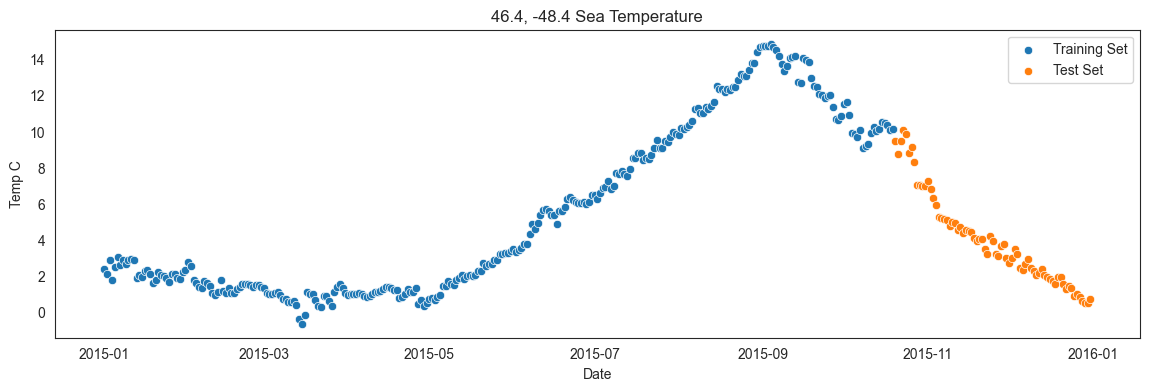

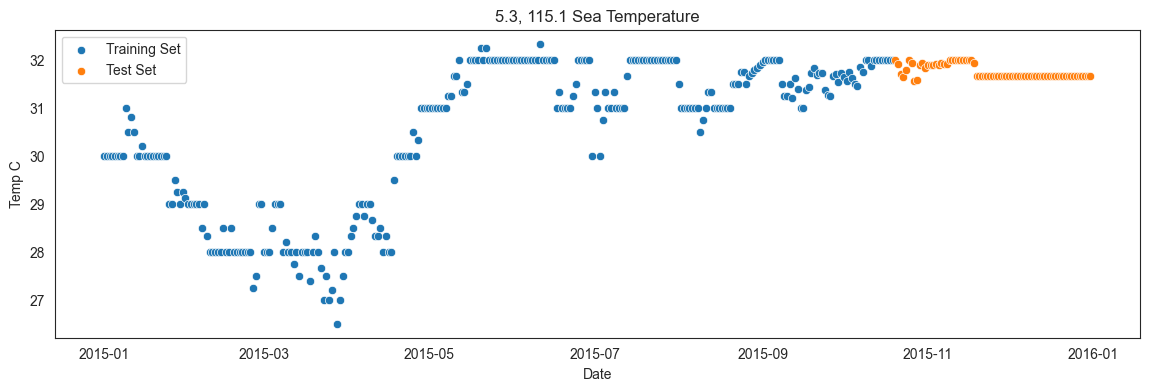

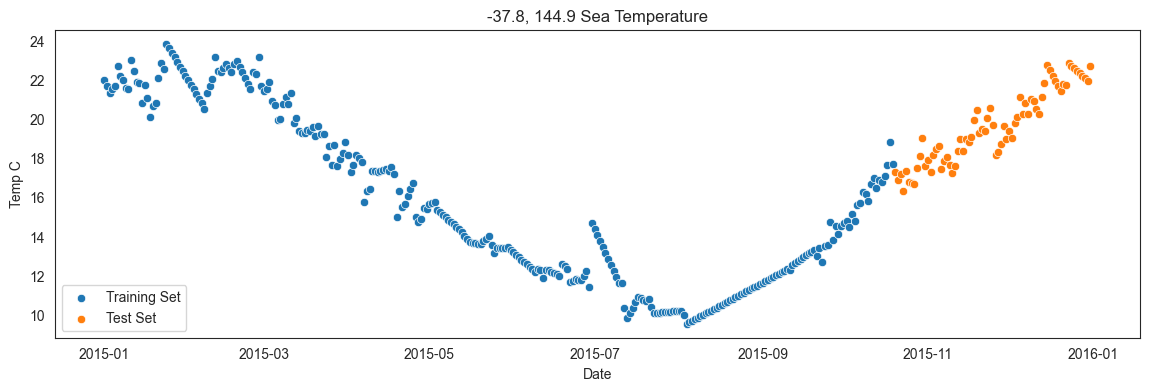

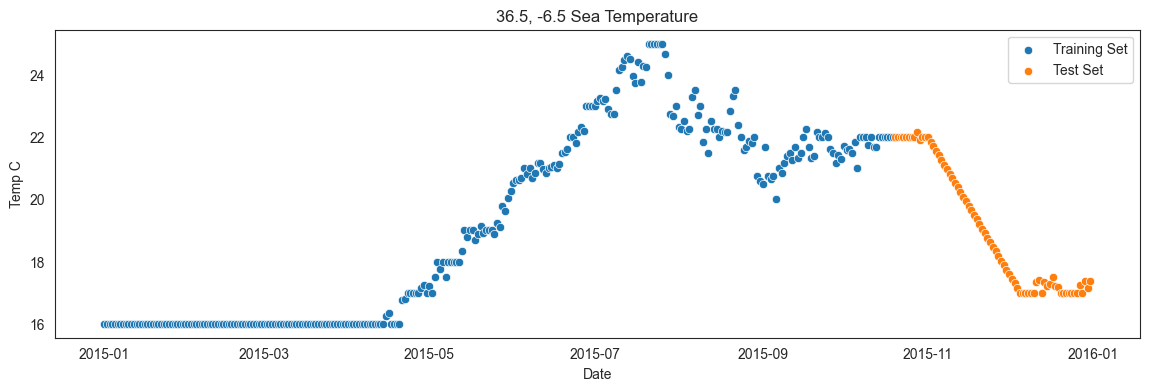

In [391]:
import seaborn as sns

for i in df['lat, long'].unique():
    plt.figure(figsize=(14,4))
    sns.scatterplot(y=df_new[i]["Train"]['full_sea'], x=df_new[i]['Train']['timestamp'])
    sns.scatterplot(y=df_new[i]["Test"]['full_sea'], x=df_new[i]['Test']['timestamp'])
    plt.ylabel("Temp C")
    plt.xlabel("Date")
    plt.legend(["Training Set", "Test Set"])
    plt.title(i + " Sea Temperature")

In [392]:
from sklearn.preprocessing import MinMaxScaler

transform_train = {}
transform_test = {}
scaler = {}

for num, i in enumerate(df['lat, long'].unique()):
    sc = MinMaxScaler(feature_range=(0,1))
    a0 = np.array(df_new[i]["Train"]['full_sea'])
    a1 = np.array(df_new[i]["Test"]['full_sea'])
    a0 = a0.reshape(a0.shape[0],1)
    a1 = a1.reshape(a1.shape[0],1)
    transform_train[i] = sc.fit_transform(a0)
    transform_test[i] = sc.fit_transform(a1)
    scaler[i] = sc
    
del a0
del a1

In [393]:
for i in transform_train.keys():
    print(i, transform_train[i].shape)

print("\n")   

for i in transform_test.keys():
    print(i, transform_test[i].shape)

46.4, -48.4 (292, 1)
5.3, 115.1 (292, 1)
-37.8, 144.9 (292, 1)
36.5, -6.5 (292, 1)


46.4, -48.4 (73, 1)
5.3, 115.1 (73, 1)
-37.8, 144.9 (73, 1)
36.5, -6.5 (73, 1)


In [394]:
def dataload(seq):
    trainset = {}
    testset = {}

    for j in df['lat, long'].unique():
        trainset[j] = {}
        X_train = []
        y_train = []
        
        for i in range(seq, 292):
            X_train.append(transform_train[j][i-seq:i,0])
            y_train.append(transform_train[j][i,0])
        
        X_train, y_train = np.array(X_train), np.array(y_train)
        trainset[j]["X"] = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))
        trainset[j]["y"] = y_train
        
        testset[j] = {}
        X_test = []
        y_test = []    
        
        for i in range(seq, 73):
            X_test.append(transform_test[j][i-seq:i,0])
            y_test.append(transform_test[j][i,0])
        
        X_test, y_test = np.array(X_test), np.array(y_test)
        testset[j]["X"] = np.reshape(X_test, (X_test.shape[0], X_train.shape[1], 1))
        testset[j]["y"] = y_test

    return trainset, testset

In [395]:
trainset, testset = dataload(7)

In [396]:
arr_buff = []

for i in df['lat, long'].unique():
    buff = {}
    buff["X_train"] = trainset[i]["X"].shape
    buff["y_train"] = trainset[i]["y"].shape
    buff["X_test"] = testset[i]["X"].shape
    buff["y_test"] = testset[i]["y"].shape
    arr_buff.append(buff)

pd.DataFrame(arr_buff, index=df['lat, long'].unique())

,X_train,y_train,X_test,y_test
"46.4, -48.4","(285, 7, 1)","(285,)","(66, 7, 1)","(66,)"
"5.3, 115.1","(285, 7, 1)","(285,)","(66, 7, 1)","(66,)"
"-37.8, 144.9","(285, 7, 1)","(285,)","(66, 7, 1)","(66,)"
"36.5, -6.5","(285, 7, 1)","(285,)","(66, 7, 1)","(66,)"


In [397]:
import torch
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        # Forward propagate RNN
        out, _ = self.rnn(x, h0)

        # Decode the hidden state of the last time step
        out = self.fc(out[:, -1, :])
        return out

# Example usage:
# Define input parameters
input_size = 1  # Number of features in input data (e.g., time series)
hidden_size = 20  # Number of hidden units in the RNN
num_layers = 2  # Number of RNN layers
output_size = 1  # Number of features in output data (e.g., regression target)

# Instantiate the model
rnn = RNN(input_size, hidden_size, num_layers, output_size)

# Print model architecture
print(rnn)

RNN(
  (rnn): RNN(1, 20, num_layers=2, batch_first=True)
  (fc): Linear(in_features=20, out_features=1, bias=True)
)


In [398]:
import torch.optim as optim
import torch.nn as nn

# Define the LSTM model
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

# Example usage:
# Define input parameters
input_size = 1  # Number of features in input data (e.g., time series)
hidden_size = 20  # Number of hidden units in the LSTM
num_layers = 2  # Number of LSTM layers
output_size = 1  # Number of features in output data (e.g., regression target)

# Instantiate the model
lstm = LSTM(input_size, hidden_size, num_layers, output_size)

# Print model architecture
print(lstm)

LSTM(
  (lstm): LSTM(1, 20, num_layers=2, batch_first=True)
  (fc): Linear(in_features=20, out_features=1, bias=True)
)


In [399]:
def train(model, eval=str):
    preds = {}

    # Define the loss function
    if eval == "L1":
        criterion = nn.L1Loss()  # Mean Absolute Error (MAE) loss
    
    if eval == "MSE":
        criterion = nn.MSELoss()  # Mean Squared Error (MSE) loss

    # Define the optimizer
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    for i in df['lat, long'].unique():
        # Convert numpy arrays to PyTorch tensors
        X_train = torch.tensor(trainset[i]["X"], dtype=torch.float32)
        y_train = torch.tensor(trainset[i]["y"], dtype=torch.float32)
        
        num_epochs = 500
        # Training loop
        for epoch in range(num_epochs):
            # Forward pass
            outputs = model(X_train)
            
            # Calculate loss
            loss = criterion(outputs, y_train.reshape(-1, 1))
            
            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            print(f'Epoch {epoch+1}, Loss: {loss.item()}')

        # Evaluation
        with torch.no_grad():
            model.eval()  # Set the model to evaluation mode
            outputs = model(X_train)
            
            # Reshape the target data to match the shape of the model's output
            y_train_reshaped = y_train.reshape(-1, 1)
            
            loss_train = criterion(outputs, y_train_reshaped)
            print(f'\nMAE Loss on Training Set for {i}: {loss_train.item():.4f}')
            preds[i] = scaler[i].inverse_transform(outputs.numpy())

            # Calculate training accuracy
            train_accuracy = torch.mean(torch.abs(outputs - y_train)).item()

        # Evaluate on test set
        X_test = torch.tensor(testset[i]["X"], dtype=torch.float32)
        y_test = torch.tensor(testset[i]["y"], dtype=torch.float32)
        
        with torch.no_grad():
            model.eval()  # Set the model to evaluation mode
            test_outputs = model(X_test)
            test_accuracy = torch.mean(torch.abs(test_outputs - y_test)).item()
            loss_test = criterion(test_outputs, y_test.reshape(-1, 1))
            preds[i] = scaler[i].inverse_transform(test_outputs.numpy())

        # Print progress
        print(f'\nEpoch [{epoch+1}/{num_epochs}], Training {eval}: {loss_train:.4f}, Test {eval}: {loss_test:.4f}')

        model.train()  # Set the model back to training mode
    
    return preds

In [410]:
rnn_preds = train(rnn, eval="L1")

Epoch 1, Loss: 0.01713588461279869
Epoch 2, Loss: 0.030421648174524307
Epoch 3, Loss: 0.019825687631964684
Epoch 4, Loss: 0.017587540671229362
Epoch 5, Loss: 0.022162824869155884
Epoch 6, Loss: 0.020066095516085625
Epoch 7, Loss: 0.015708474442362785
Epoch 8, Loss: 0.01686651073396206
Epoch 9, Loss: 0.019331663846969604
Epoch 10, Loss: 0.01809917576611042
Epoch 11, Loss: 0.015443127602338791
Epoch 12, Loss: 0.015587436966598034
Epoch 13, Loss: 0.017533455044031143
Epoch 14, Loss: 0.01749463938176632
Epoch 15, Loss: 0.01578623056411743
Epoch 16, Loss: 0.015121113508939743
Epoch 17, Loss: 0.016147486865520477
Epoch 18, Loss: 0.016665365546941757
Epoch 19, Loss: 0.015921534970402718
Epoch 20, Loss: 0.015182431787252426
Epoch 21, Loss: 0.015482818707823753
Epoch 22, Loss: 0.01587754115462303
Epoch 23, Loss: 0.015553263947367668
Epoch 24, Loss: 0.015157868154346943
Epoch 25, Loss: 0.015305054374039173
Epoch 26, Loss: 0.01555230189114809
Epoch 27, Loss: 0.015330188907682896
Epoch 28, Loss: 0

In [411]:
lstm_preds = train(lstm, eval="L1")

Epoch 1, Loss: 0.01571887731552124
Epoch 2, Loss: 0.040757667273283005
Epoch 3, Loss: 0.01710348203778267
Epoch 4, Loss: 0.02955738455057144
Epoch 5, Loss: 0.0308162160217762
Epoch 6, Loss: 0.02023405209183693
Epoch 7, Loss: 0.015928024426102638
Epoch 8, Loss: 0.023357084020972252
Epoch 9, Loss: 0.02474953420460224
Epoch 10, Loss: 0.019970521330833435
Epoch 11, Loss: 0.015750935301184654
Epoch 12, Loss: 0.018230734393000603
Epoch 13, Loss: 0.021283430978655815
Epoch 14, Loss: 0.020106086507439613
Epoch 15, Loss: 0.016457902267575264
Epoch 16, Loss: 0.015460018999874592
Epoch 17, Loss: 0.018095090985298157
Epoch 18, Loss: 0.019202010706067085
Epoch 19, Loss: 0.017307069152593613
Epoch 20, Loss: 0.015411093831062317
Epoch 21, Loss: 0.016192318871617317
Epoch 22, Loss: 0.01769210211932659
Epoch 23, Loss: 0.017276423051953316
Epoch 24, Loss: 0.01573004014790058
Epoch 25, Loss: 0.01530942041426897
Epoch 26, Loss: 0.016357332468032837
Epoch 27, Loss: 0.01681317761540413
Epoch 28, Loss: 0.015

# Visualizing Results

## RNN

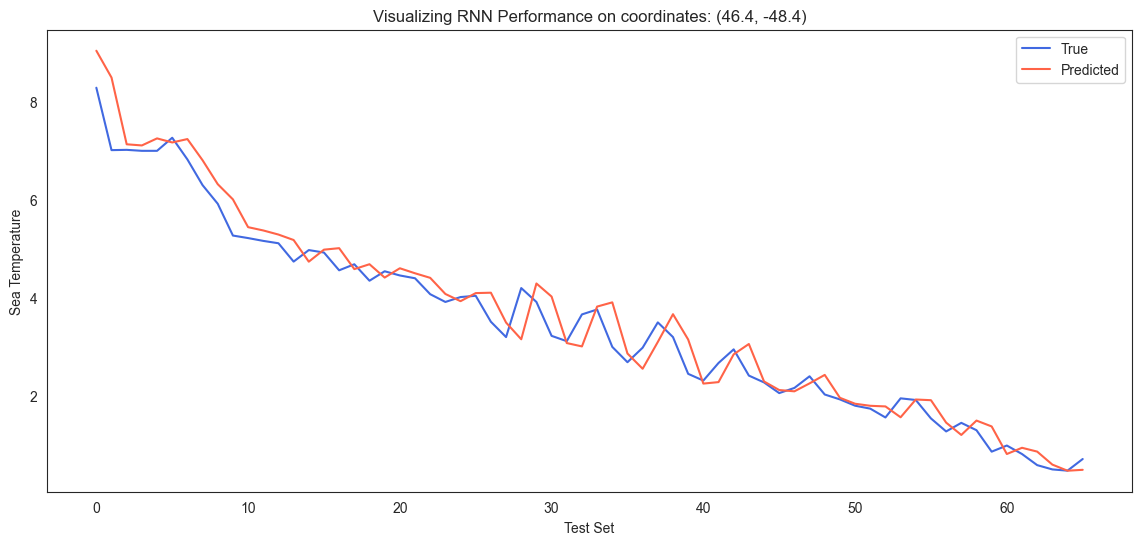

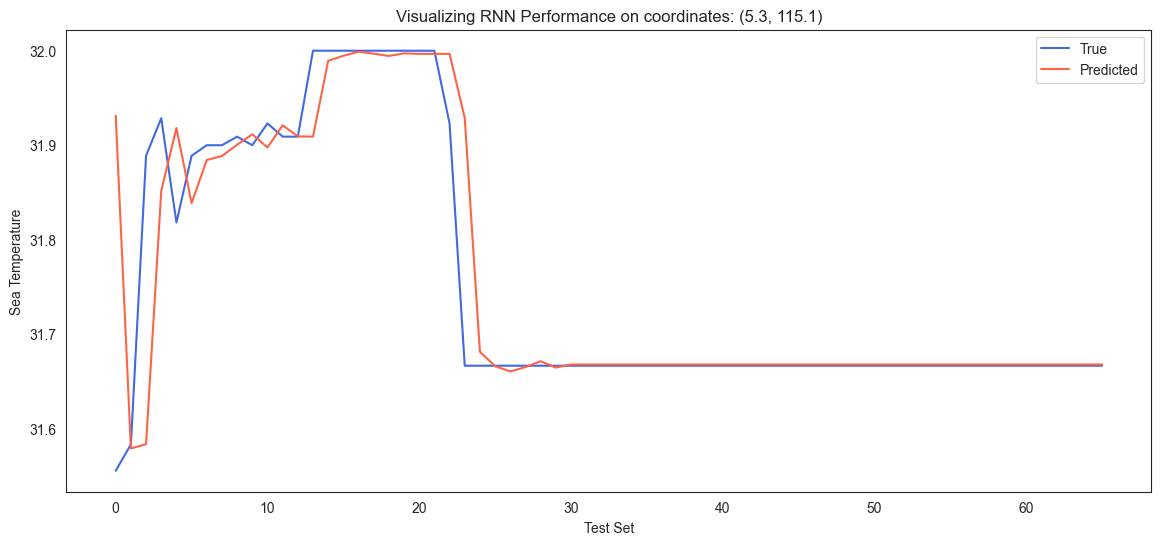

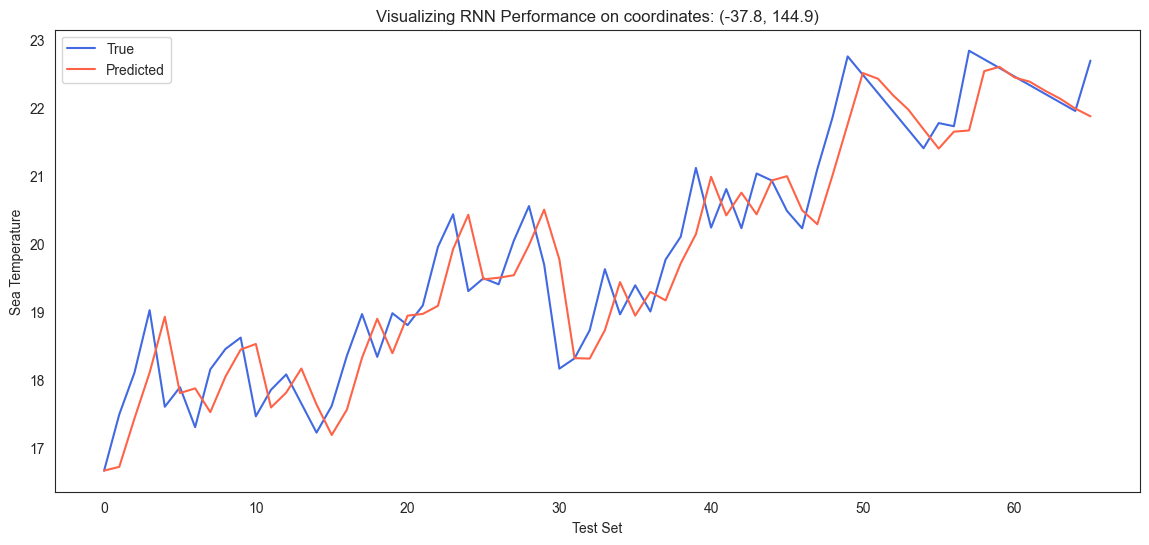

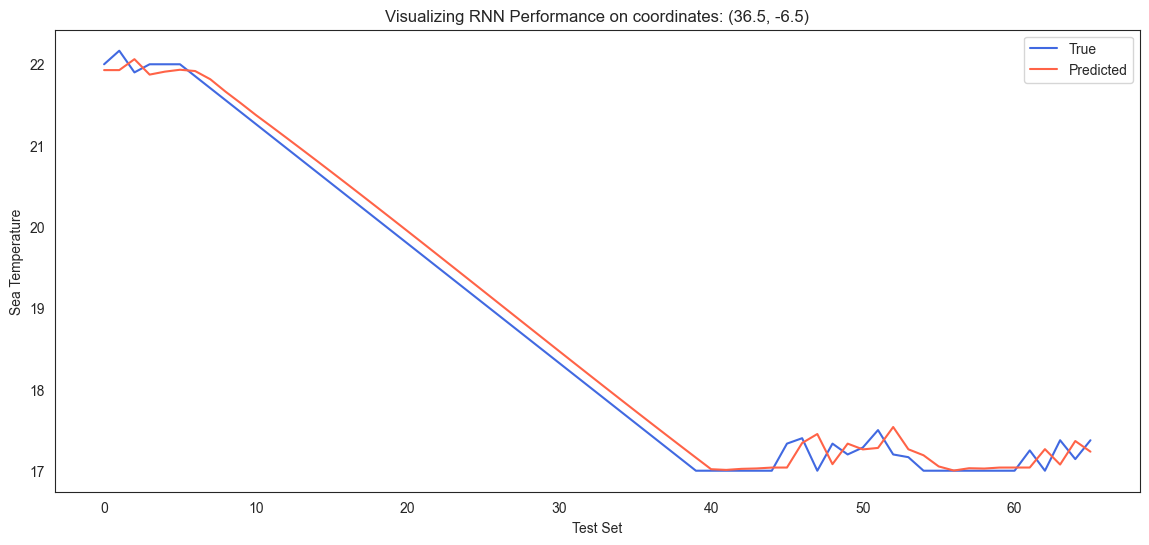

In [412]:
for i in df['lat, long'].unique():
    y_true = scaler[i].inverse_transform(testset[i]["y"].reshape(-1,1))
    y_pred = rnn_preds[i]
    
    plt.figure(figsize=(14,6))

    plt.xlabel('Test Set')
    plt.ylabel('Sea Temperature')
    plt.title(f'Visualizing RNN Performance on coordinates: ({i})')

    sns.lineplot(y_true.flatten(), color='royalblue', label='True')
    sns.lineplot(y_pred.flatten(), color='tomato', label='Predicted')
    plt.show()

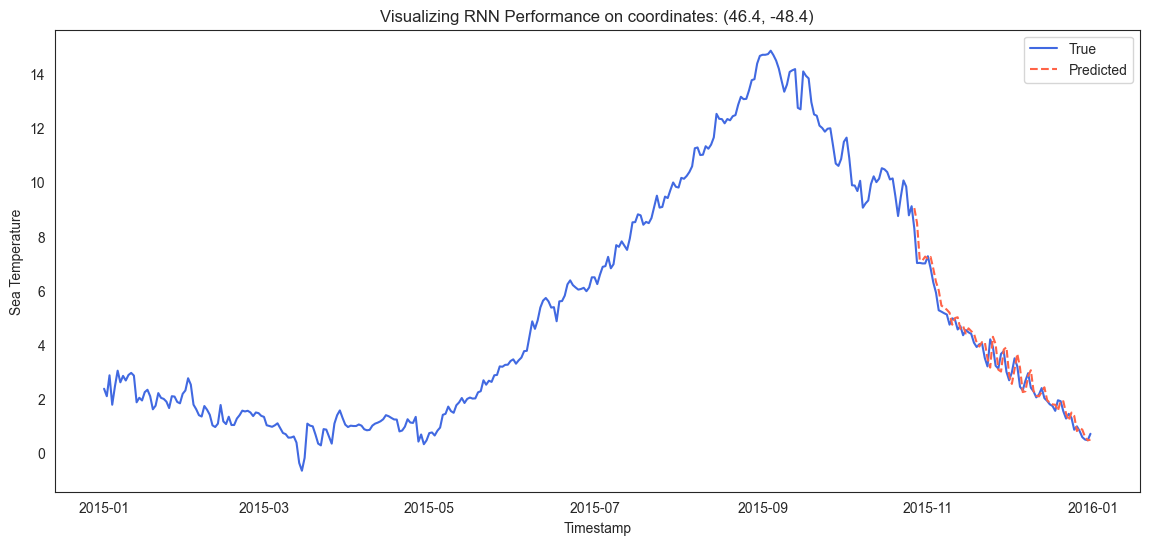

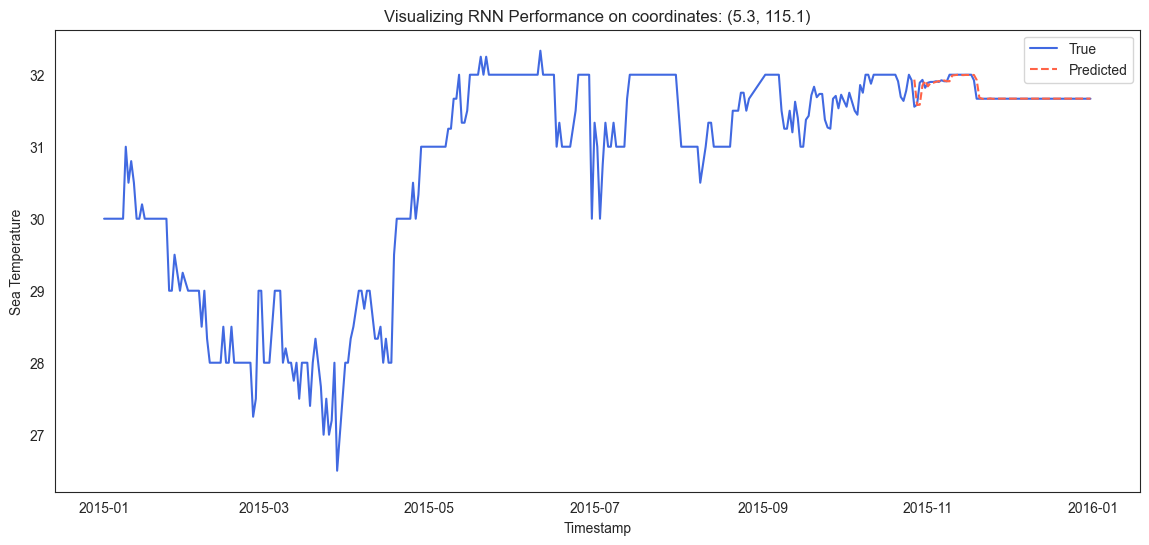

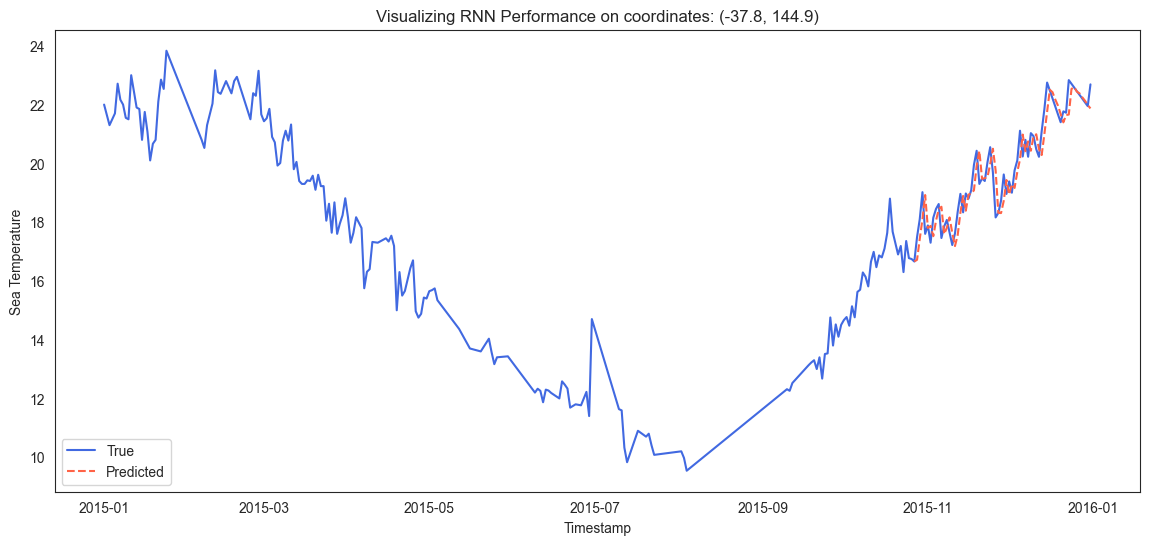

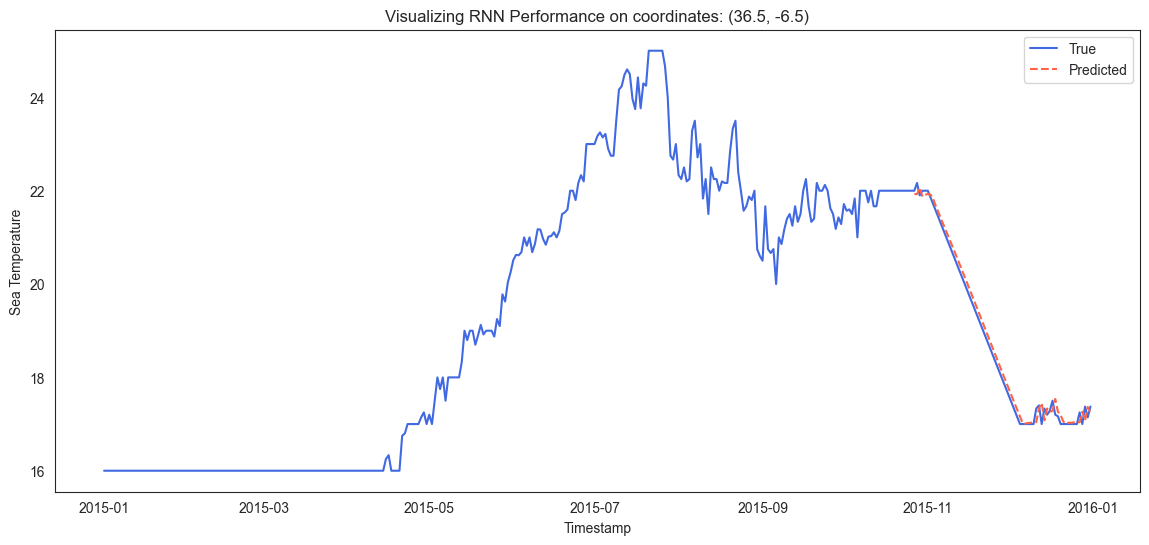

In [413]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
sns.set_style("white")


# Define timestamp
timestamp = df['timestamp'].unique()

for i in df['lat, long'].unique():
    temps = rnn_preds[i].reshape(-1)
    adj = timestamp[365 - len(rnn_preds[i]):]
    temps = pd.DataFrame({'timestamp': adj, 'temps': temps})
    
    sub = df[df['lat, long'] == i]

    plt.figure(figsize=(14,6))
    
    # Plot true sea temperature
    sns.lineplot(data=sub, x='timestamp', y='full_sea', label='True', color='royalblue')
    
    # Plot predicted sea temperature
    sns.lineplot(data=temps, x='timestamp', y='temps', label='Predicted', color='tomato', linestyle='--')
    
    # Add labels and legend
    plt.xlabel('Timestamp')
    plt.ylabel('Sea Temperature')
    plt.title(f'Visualizing RNN Performance on coordinates: ({i})')
    plt.legend()
    
    # Show plot
    plt.show()


## LSTM

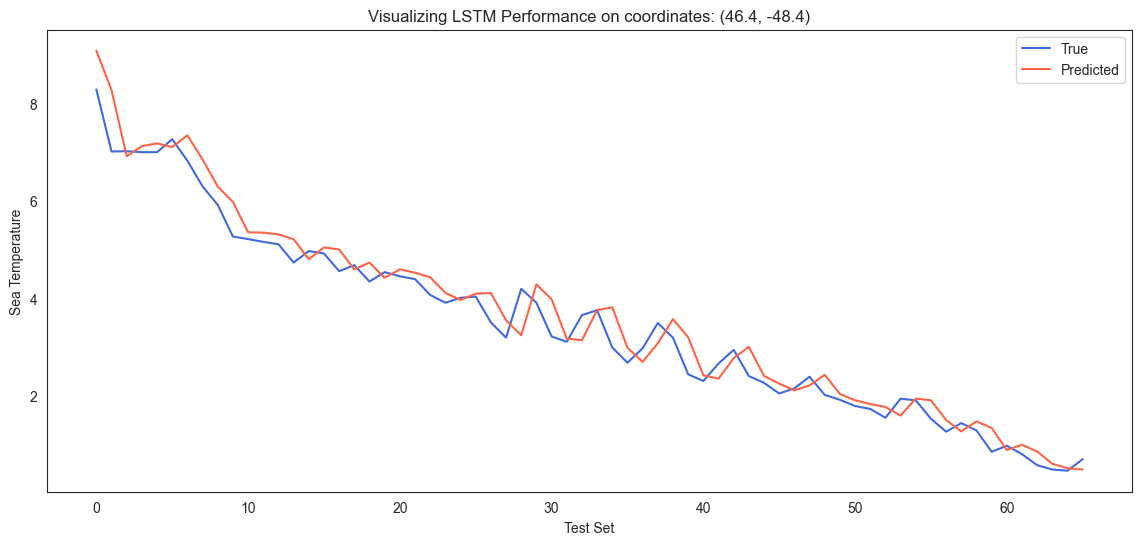

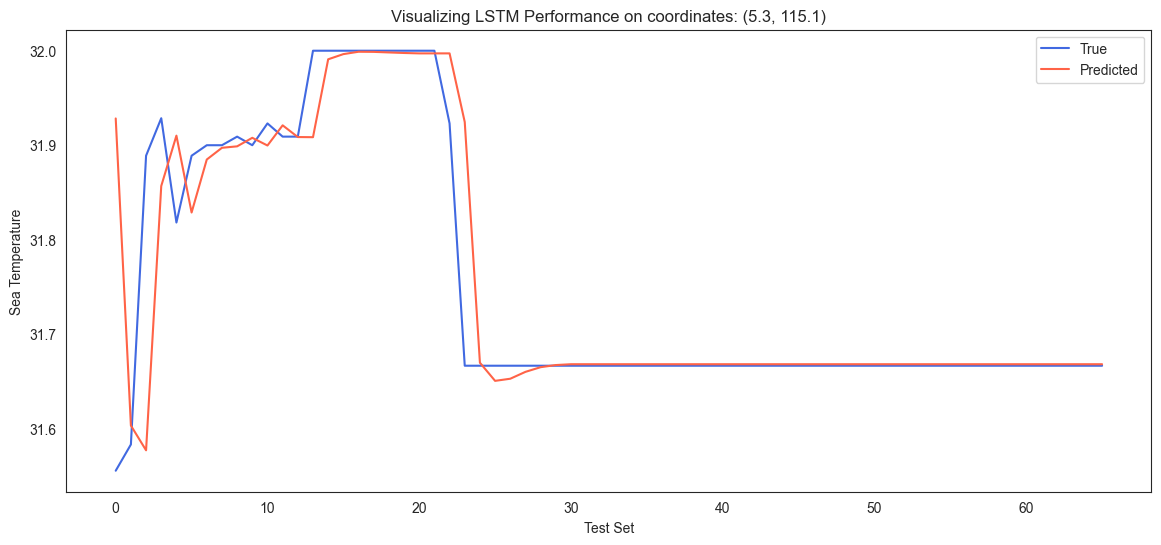

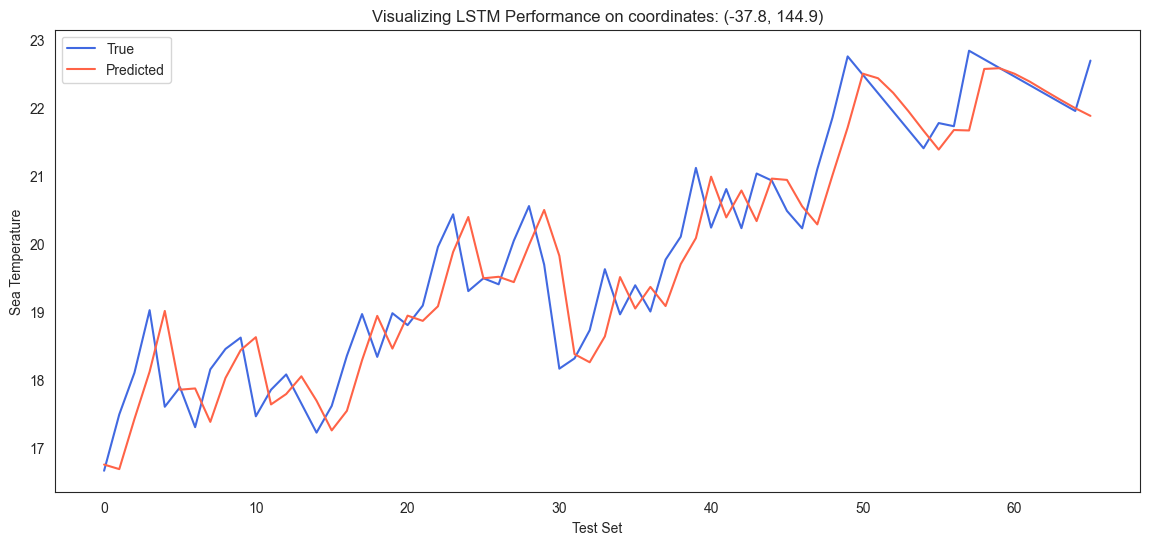

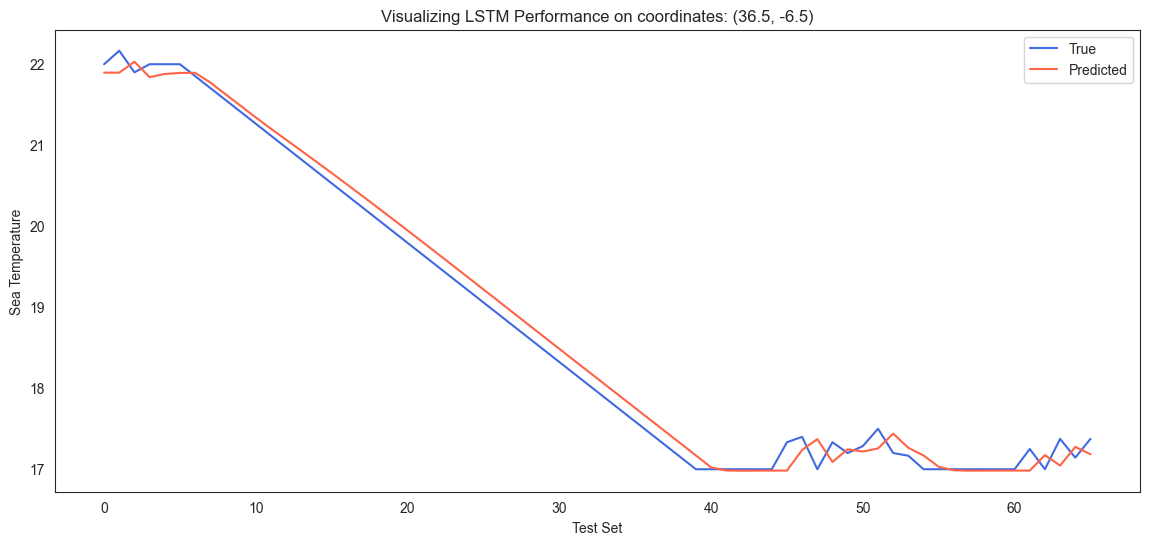

In [414]:
for i in df['lat, long'].unique():
    y_true = scaler[i].inverse_transform(testset[i]["y"].reshape(-1,1))
    y_pred = lstm_preds[i]
    
    plt.figure(figsize=(14,6))

    plt.xlabel('Test Set')
    plt.ylabel('Sea Temperature')
    plt.title(f'Visualizing LSTM Performance on coordinates: ({i})')

    sns.lineplot(y_true.flatten(), color='royalblue', label='True')
    sns.lineplot(y_pred.flatten(), color='tomato', label='Predicted')
    plt.show()

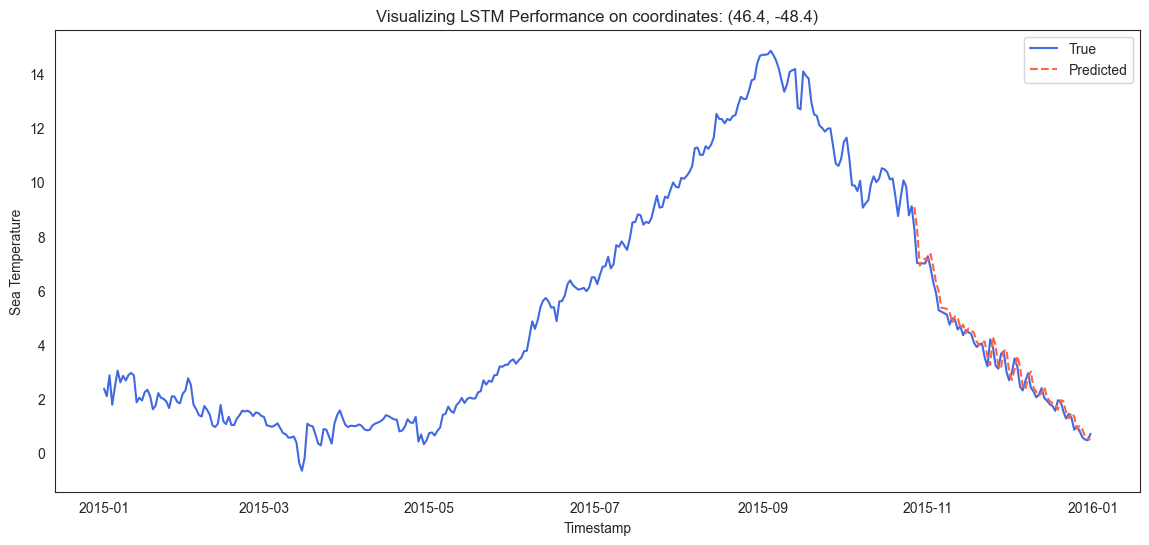

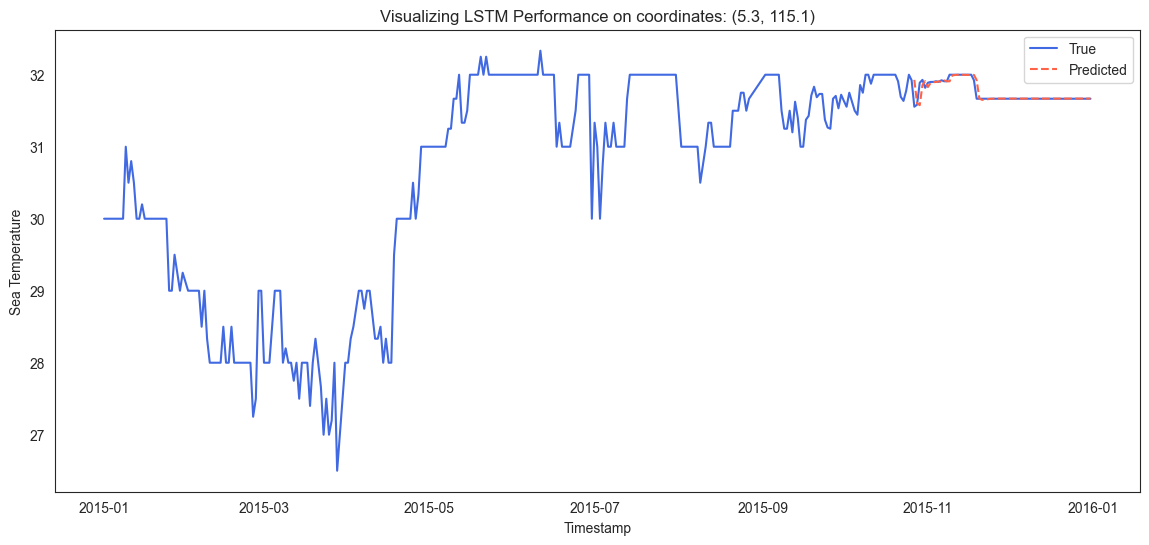

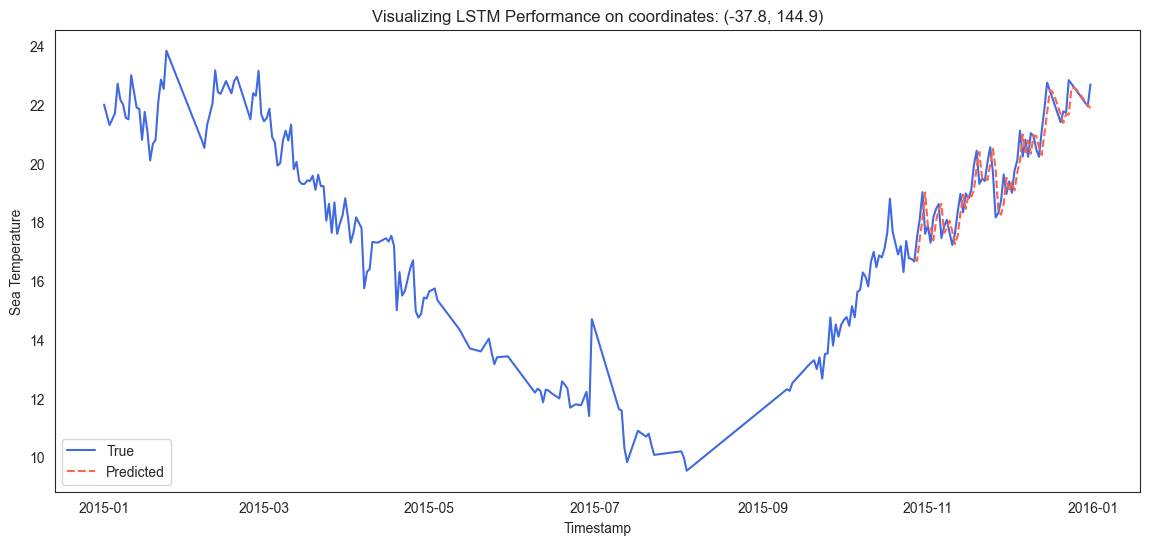

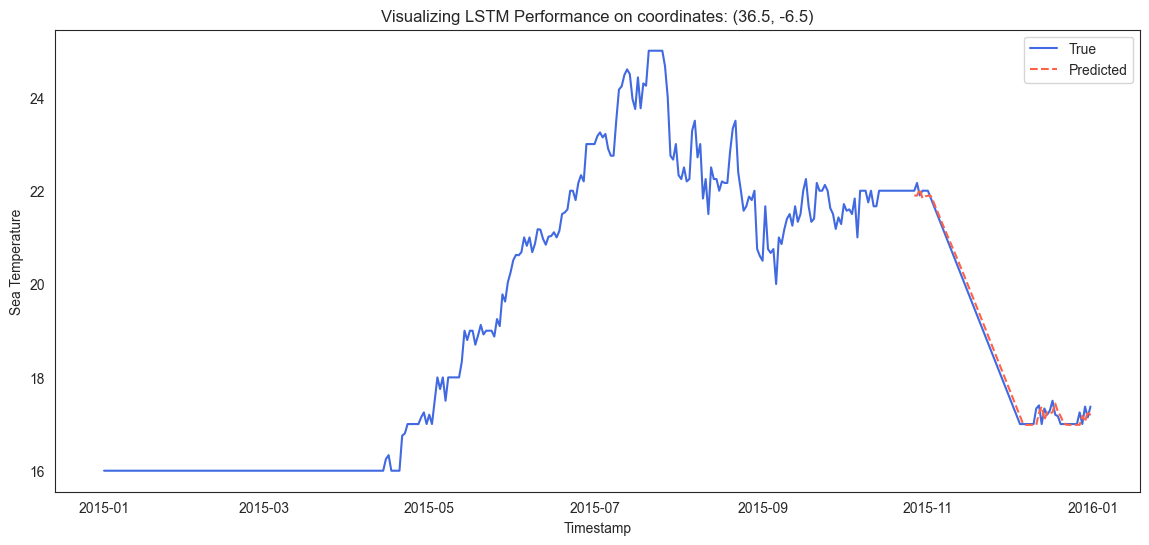

In [415]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
sns.set_style("white")

# Define timestamp
timestamp = df['timestamp'].unique()

for i in df['lat, long'].unique():
    temps = lstm_preds[i].reshape(-1)
    adj = timestamp[365 - len(lstm_preds[i]):]
    temps = pd.DataFrame({'timestamp': adj, 'temps': temps})
    
    sub = df[df['lat, long'] == i]

    plt.figure(figsize=(14,6))
    
    # Plot true sea temperature
    sns.lineplot(data=sub, x='timestamp', y='full_sea', label='True', color='royalblue')
    
    # Plot predicted sea temperature
    sns.lineplot(data=temps, x='timestamp', y='temps', label='Predicted', color='tomato', linestyle='--')
    
    # Add labels and legend
    plt.xlabel('Timestamp')
    plt.ylabel('Sea Temperature')
    plt.title(f'Visualizing LSTM Performance on coordinates: ({i})')
    plt.legend()
    
    # Show plot
    plt.show()


# Comparing Models

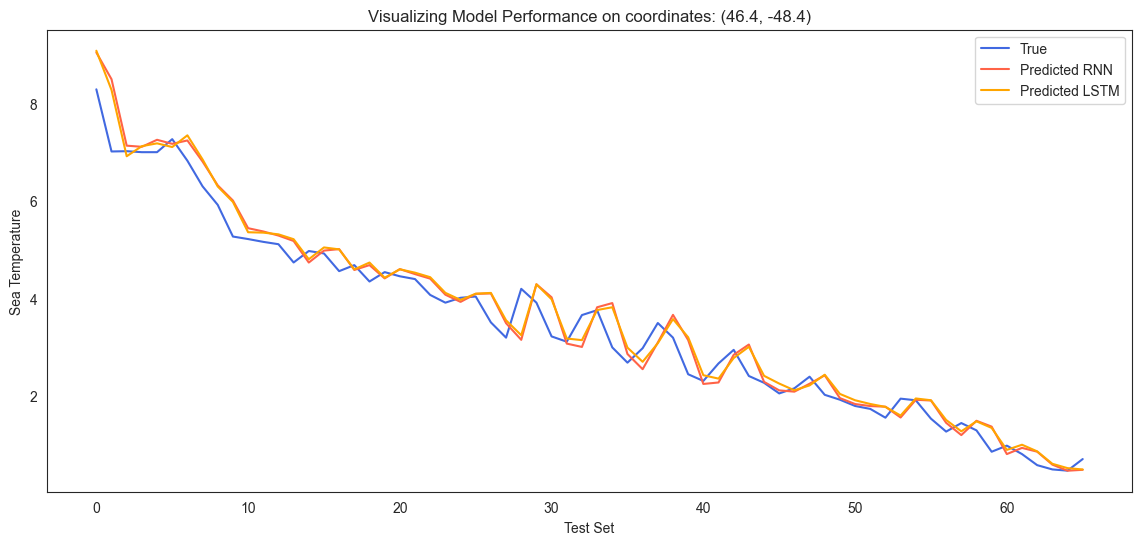

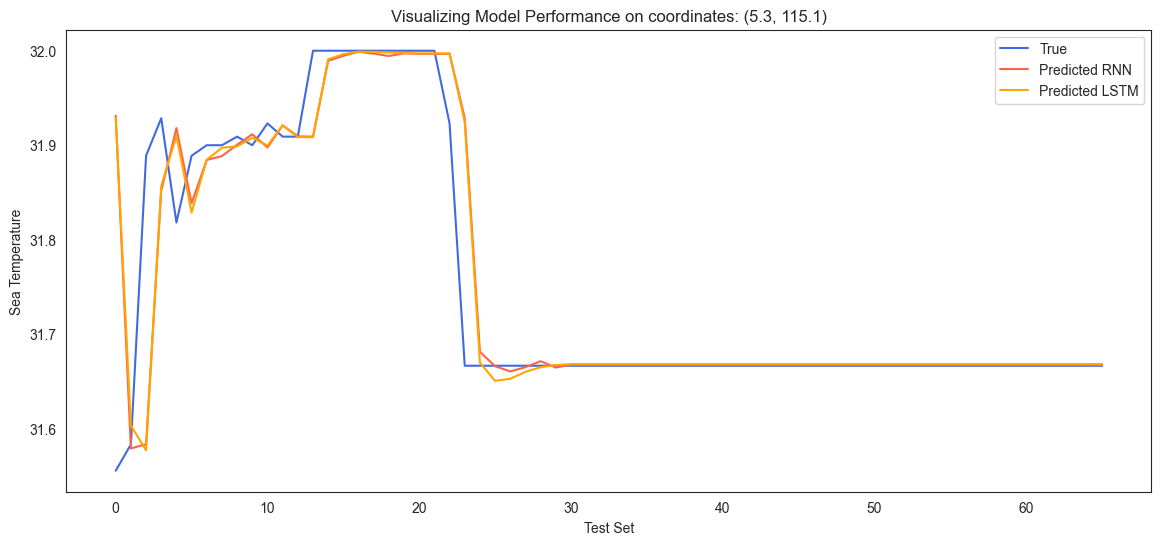

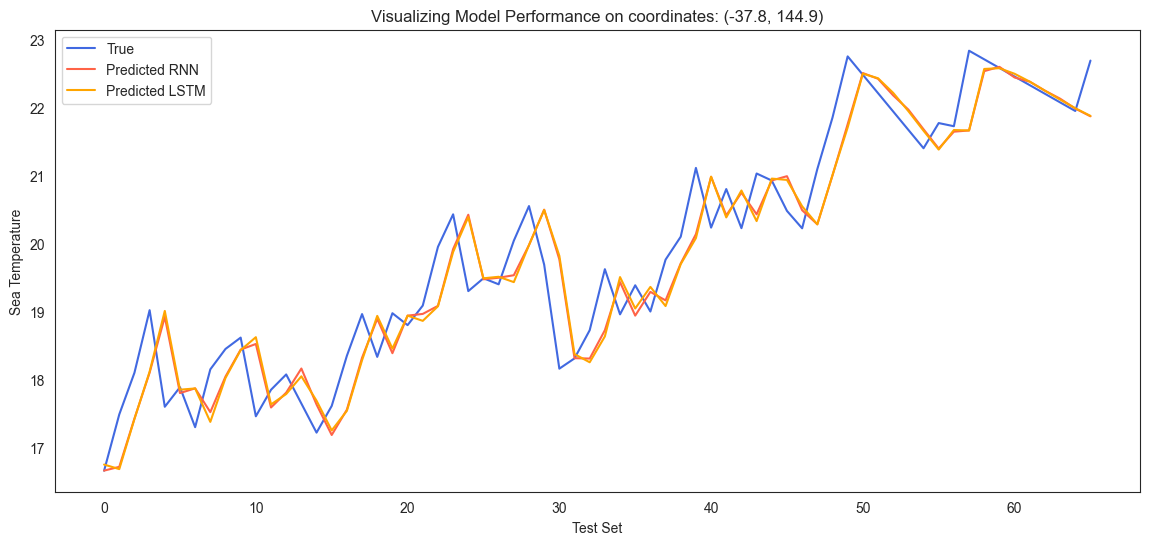

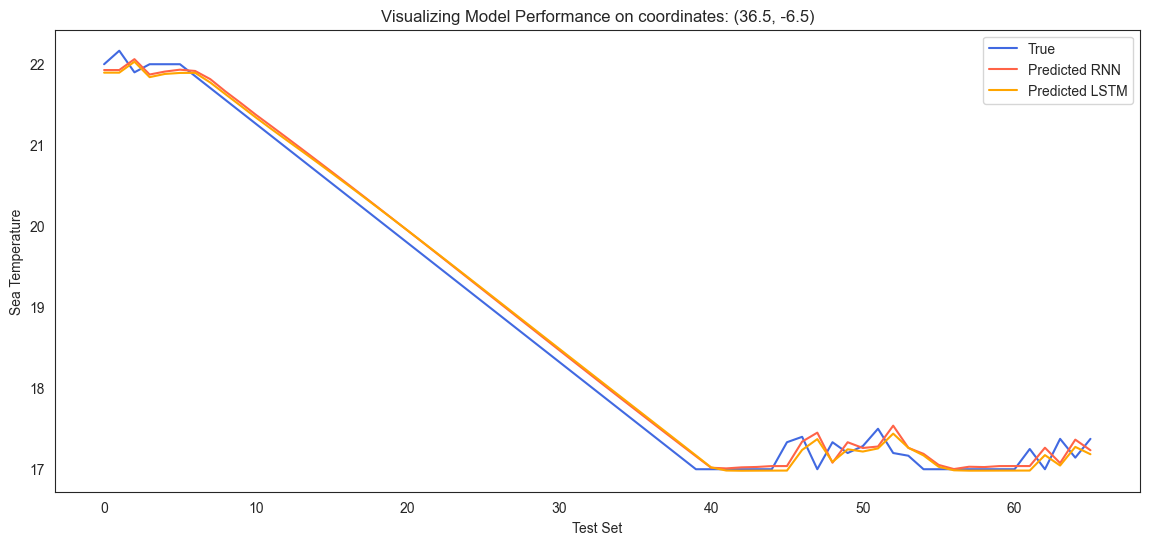

In [416]:
for i in df['lat, long'].unique():
    y_true = scaler[i].inverse_transform(testset[i]["y"].reshape(-1,1))
    y_pred_rnn = rnn_preds[i]
    y_pred_lstm = lstm_preds[i]
    
    plt.figure(figsize=(14,6))

    plt.xlabel('Test Set')
    plt.ylabel('Sea Temperature')
    plt.title(f'Visualizing Model Performance on coordinates: ({i})')

    sns.lineplot(y_true.flatten(), color='royalblue', label='True')
    sns.lineplot(y_pred_rnn.flatten(), color='tomato', label='Predicted RNN')
    sns.lineplot(y_pred_lstm.flatten(), color='orange', label='Predicted LSTM')
    plt.show()

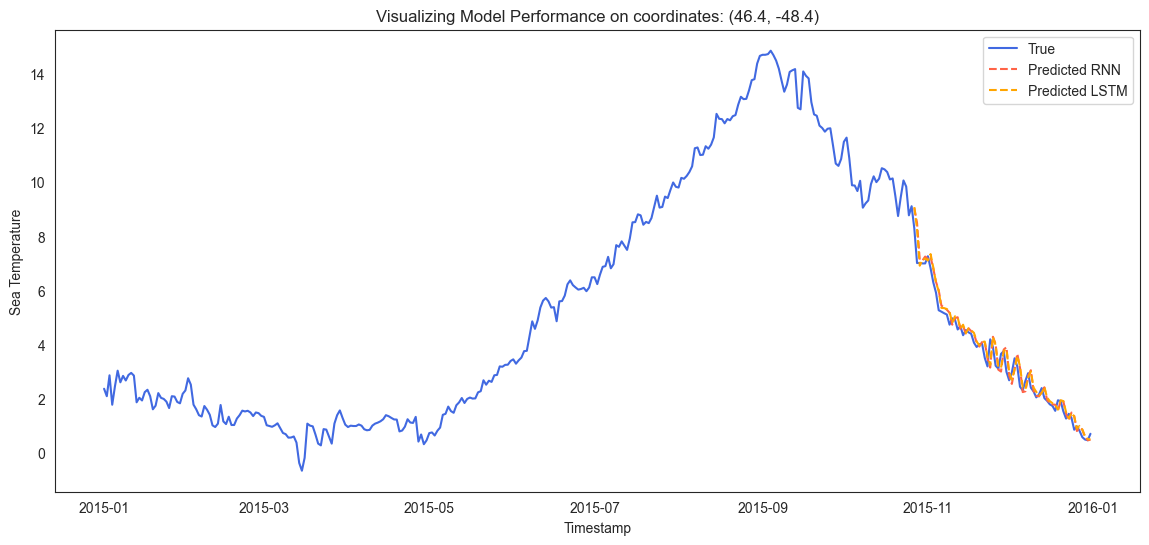

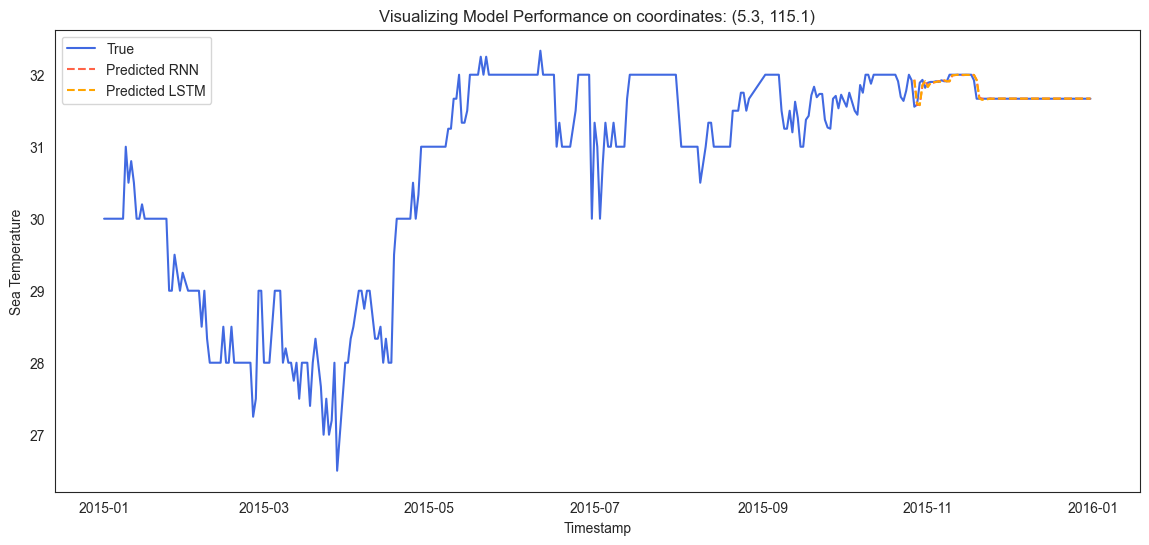

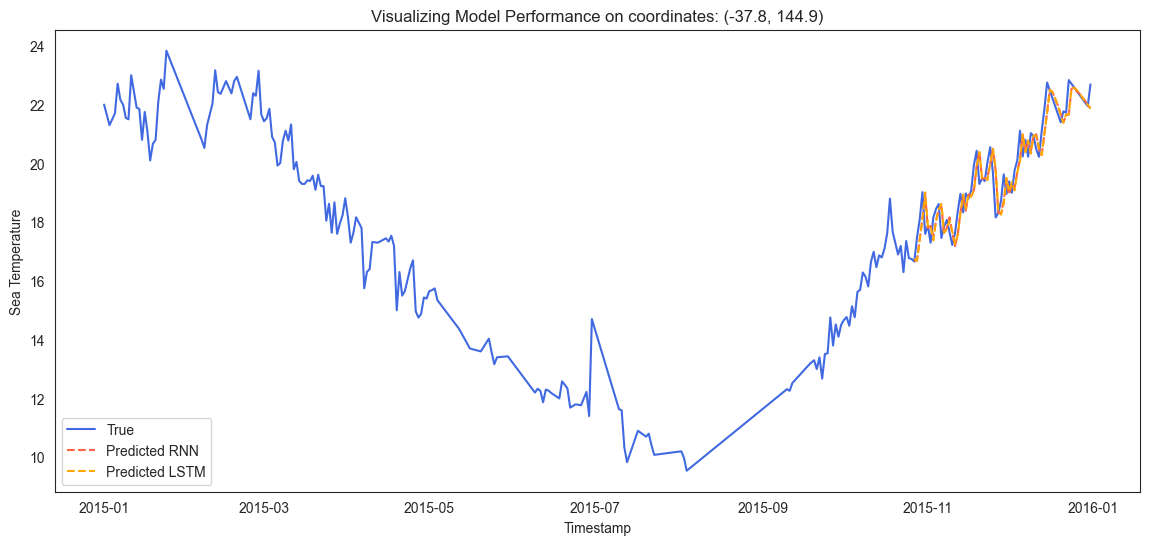

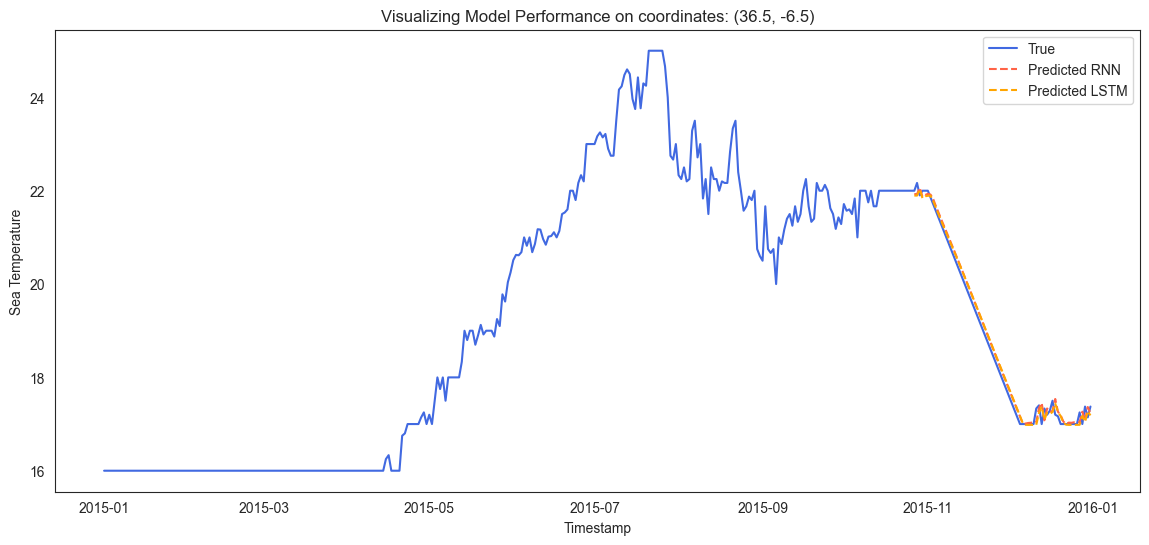

In [417]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
sns.set_style("white")

# Define timestamp
timestamp = df['timestamp'].unique()

for i in df['lat, long'].unique():
    temps = rnn_preds[i].reshape(-1)
    adj = timestamp[365 - len(lstm_preds[i]):]
    
    temps_rnn = pd.DataFrame({'timestamp': adj, 'temps': temps})

    temps = lstm_preds[i].reshape(-1)
    temps_lstm = pd.DataFrame({'timestamp': adj, 'temps': temps})
    
    sub = df[df['lat, long'] == i]

    plt.figure(figsize=(14,6))
    
    # Plot true sea temperature
    sns.lineplot(data=sub, x='timestamp', y='full_sea', label='True', color='royalblue')
    sns.lineplot(data=temps_rnn, x='timestamp', y='temps', label='Predicted RNN', color='tomato', linestyle='--')
    sns.lineplot(data=temps_lstm, x='timestamp', y='temps', label='Predicted LSTM', color='orange', linestyle='--')
    
    # Add labels and legend
    plt.xlabel('Timestamp')
    plt.ylabel('Sea Temperature')
    plt.title(f'Visualizing Model Performance on coordinates: ({i})')
    plt.legend()
    
    # Show plot
    plt.show()
